In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import resize as r
# 读取拼接图片
from Stitcher import Stitcher
stitcher = Stitcher()


In [2]:
def calculate_homography(src_points, dst_points):
    # Ensure there are at least four points in each set
    if src_points.shape[0] < 4 or dst_points.shape[0] < 4:
        raise ValueError("There must be at least four points in each set to calculate a homography.")

    # Construct the matrix A for the homogeneous equation system
    A = []
    for i in range(src_points.shape[0]):
        x, y = src_points[i, 0], src_points[i, 1]
        u, v = dst_points[i, 0], dst_points[i, 1]
        A.append([-x, -y, -1, 0, 0, 0, x*u, y*u, u])
        A.append([0, 0, 0, -x, -y, -1, x*v, y*v, v])

    A = np.array(A)

    # Perform SVD on matrix A
    U, S, Vt = np.linalg.svd(A)
    # The solution to the system is the last column of V (or the last row of V transposed)
    L = Vt[-1, :]
    # Reshape the solution to a 3x3 matrix
    H = L.reshape(3, 3)
    return H


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


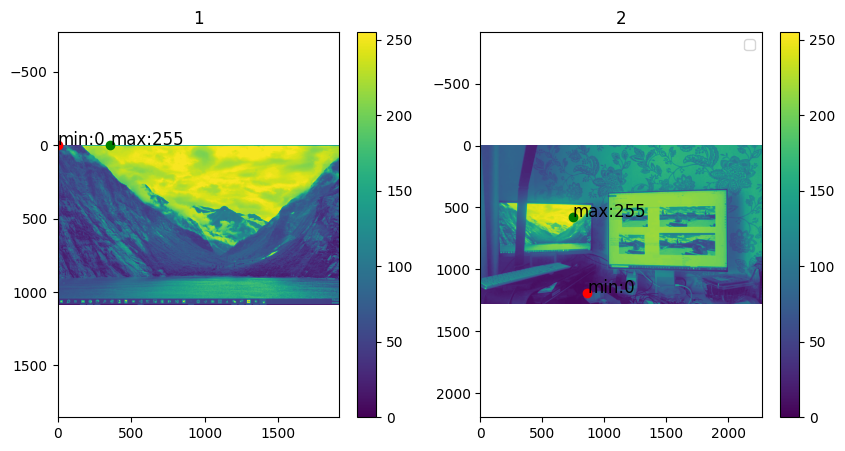

In [3]:

imageA = cv2.imread("1.png")
imageB = cv2.imread("cam2275x1280.jpg")

r.check2map(cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY),cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY))



In [4]:
# imageA = cv2.imread("left_01.png")
# imageB = cv2.imread("right_01.png")
ratio=0.75
reprojThresh=4.0
#检测A、B图片的SIFT关键特征点，并计算特征描述子
(kpsA, featuresA) = stitcher.detectAndDescribe(imageA)
(kpsB, featuresB) = stitcher.detectAndDescribe(imageB)

# 匹配两张图片的所有特征点，返回匹配结果
M = stitcher.matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh)

# 如果返回结果为空，没有匹配成功的特征点，退出算法
if M is None:
    raise ValueError("No matching points found")


# H是3x3视角变换矩阵
(matches, H, status) = M
# 将图片A进行视角变换，result是变换后图片
# result = cv2.warpPerspective(imageA, H, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
H

array([[4.49538305e-01, 2.01450029e-02, 1.45146979e+02],
       [4.06807683e-02, 4.04576101e-01, 4.63517645e+02],
       [6.37177459e-05, 3.04966683e-05, 1.00000000e+00]])

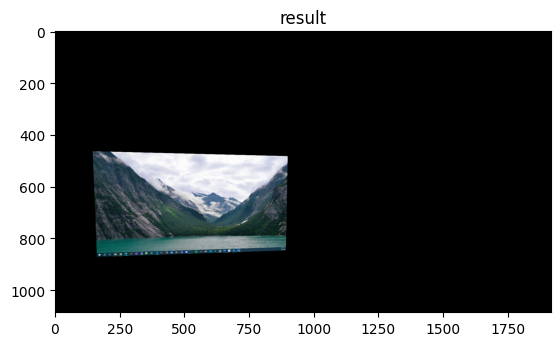

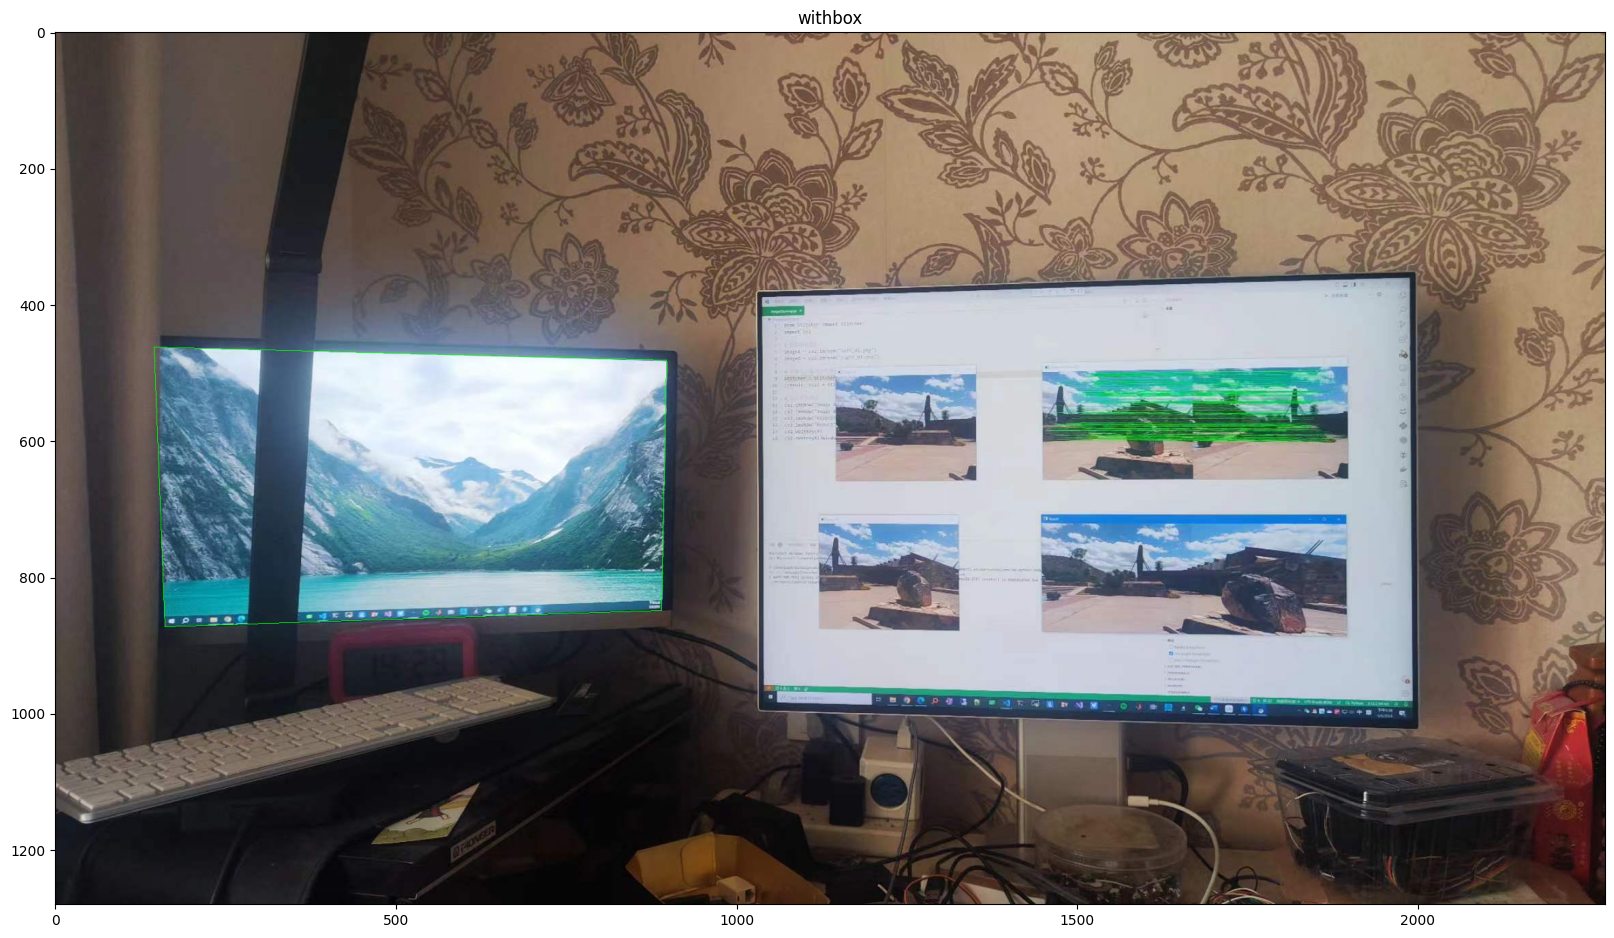

In [5]:
pro_size=(imageA.shape[1], imageA.shape[0])

result = cv2.warpPerspective(imageA, H, (imageA.shape[1], imageA.shape[0]))
r.plt_show('result', result)
reprojThresh=4.0

# result = cv2.warpPerspective(target_image, H, (cam_size[0], cam_size[1]))
# plt_show('result', result)

# img = np.ones((pro_size[1],pro_size[0]), dtype=np.uint8)*255
# img= cv2.warpPerspective(img, H, (cam_size[0], cam_size[1]))
# check2map(white_img,img)

pt1=r.fourdotclock((pro_size[0],pro_size[1]))
pt1=cv2.perspectiveTransform(pt1.reshape(-1, 1, 2),H).reshape(-1,2)
# Save the transformed 4-point coordinates to a text file
with open('transformed_coordinates.txt', 'w') as file:
    for point in pt1:
        file.write(f'{point[0]}, {point[1]}\n')

r.plt_show_withbox(imageB,pt1.reshape(-1,2))

# 注意要求逆

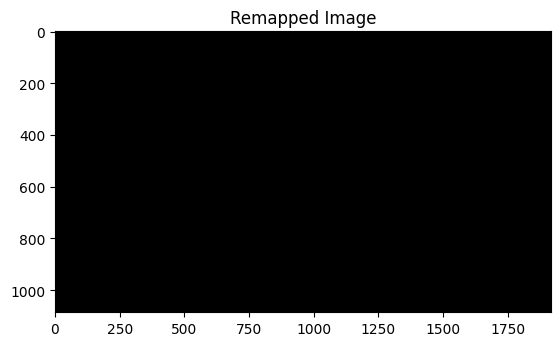

In [6]:
# Generate mapx and mapy for remapping using the homography matrix H
h, w = imageA.shape[:2]
mapx = np.zeros((h, w), dtype=np.float32)
mapy = np.zeros((h, w), dtype=np.float32)

# for y in range(h):
#     for x in range(w):
#         p = np.array([x, y, 1]).reshape(3, 1)
#         p_transformed = np.dot(np.linalg.inv(H), p)
#         p_transformed /= p_transformed[2]
#         mapx[y, x] = p_transformed[0]
#         mapy[y, x] = p_transformed[1]

# Remap the image using the generated mapx and mapy
remapped_image = cv2.remap(imageA, mapx, mapy, cv2.INTER_LINEAR)
r.plt_show('Remapped Image', remapped_image)

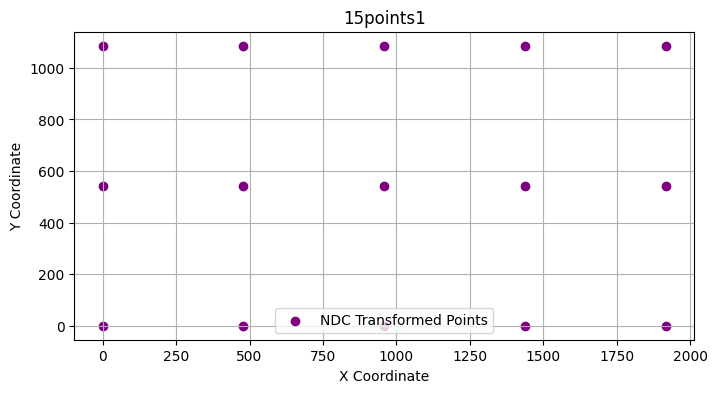

In [7]:
width,height=360,640

re=r.dotmatrix(pro_size)
r.plt_show_array("15points1",np.array(re))

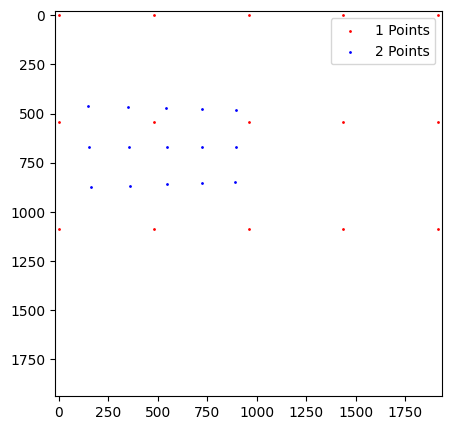

In [8]:

ree=stitcher.points_transform(np.array(re),H)
r.check2scatter(np.array(re),ree)

[[145.14697947 463.51764513]
 [161.6553135  873.57702533]
 [890.52748705 848.71655166]
 [897.30844726 482.55951944]]
[[[145.14697 463.51764]]

 [[161.65532 873.577  ]]

 [[890.52747 848.71655]]

 [[897.3085  482.5595 ]]]


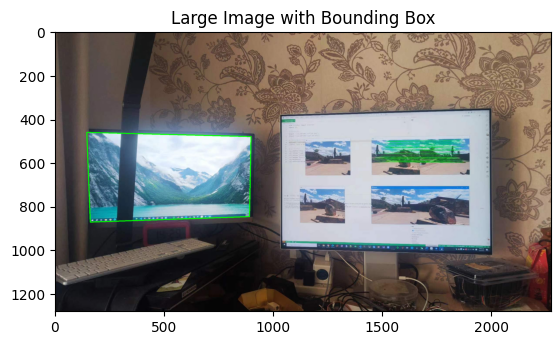

In [9]:
arr2 = np.array([[7, 8, 9], [10, 11, 12]])
h, w = imageA.shape[:2]
# 定义小图像的四个角点坐标
corners = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]])
tcorners = stitcher.points_transform(corners,H)
print(tcorners)
imgwb1 = cv2.polylines(imageB, [np.int32(tcorners)], True, (0, 255, 0), 3)
corners = corners.reshape(-1, 1, 2)
# 使用变换矩阵将小图像的四个角点映射到大图像中
tcorners2 = cv2.perspectiveTransform(corners, H)
print(tcorners2)
large_image_with_box = cv2.polylines(imageB, [np.int32(tcorners2)], True, (0, 255, 0), 3)
r.plt_show('Large Image with Bounding Box', imgwb1)



In [10]:
#插值实现投影平面和相机平面的一对一对应结果存储在cam_pro中
cam_size=imageA.shape
cam_size

(1086, 1918, 3)

In [11]:
grid_x = np.linspace(0, cam_size[0]-1, cam_size[0])  # x coordinate range
grid_y = np.linspace(0, cam_size[1]-1, cam_size[1])  # y coordinate range

grid_x, grid_y = np.meshgrid(grid_x, grid_y)

# resize.check2map(grid_x,grid_y)
points_to_remap = np.column_stack((grid_x.flatten(), grid_y.flatten()))


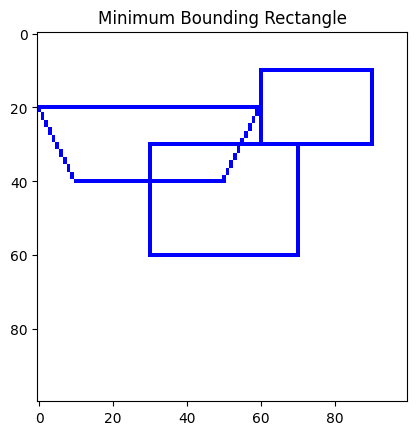

In [12]:
from shapely.geometry import Polygon
# 输入每个图形的角点
points = [
    # 第一个图形的角点坐标
    np.array([[0, 20], [60, 20], [50, 40], [10, 40]]),
    # 第二个图形的角点坐标
    np.array([[30, 30], [70, 30], [70, 60], [30, 60]]),
    # 第三个图形的角点坐标
    np.array([[60, 10], [90, 10], [90, 30], [60, 30]])
]

# 寻找最小外接矩形
enclosing_rectangle = r.find_enclosing_rectangle(points)
i=np.ones((100,100,3), dtype=np.uint8)*255
for point_set in points:
    i = cv2.polylines(i, [point_set], isClosed=True, color=(255, 0, 0), thickness=1)
re = cv2.polylines(i, [enclosing_rectangle], isClosed=True, color=(0, 255, 0), thickness=2)
r.plt_show("Minimum Bounding Rectangle",re)


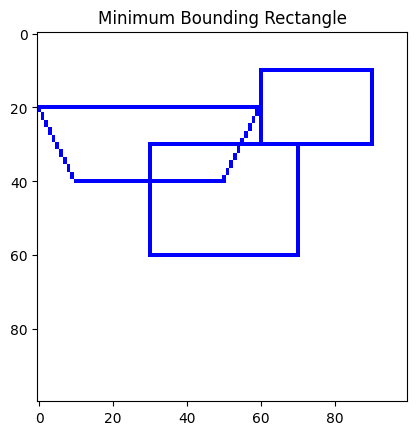

In [13]:
# 寻找最小外接矩形
enclosing_rectangle = r.find_enclosing_rectangle(points)
i=np.ones((100,100,3), dtype=np.uint8)*255
for point_set in points:
    i = cv2.polylines(i, [point_set], isClosed=True, color=(255, 0, 0), thickness=1)
re = cv2.polylines(i, [enclosing_rectangle], isClosed=True, color=(0, 255, 0), thickness=2)
r.plt_show("Minimum Bounding Rectangle",re)


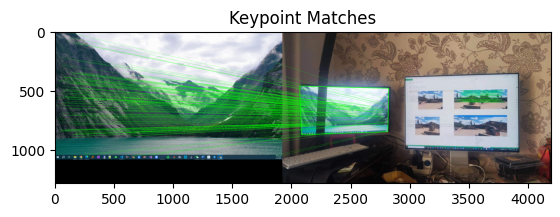

In [14]:

vis = stitcher.drawMatches(imageA, imageB, kpsA, kpsB, matches, status)
r.plt_show("Keypoint Matches", vis)


